# Interrupted time series - parameter recovery

This notebook shows an example of running Bayesian interupted time series on some synthetic data.

In [1]:
from causal_impact.causal_impact import LinearModel
from causal_impact.simulate_data import generate_interrupted_time_series_data

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Generate simulated dataset

In [4]:
treatment_time = 70
df = generate_interrupted_time_series_data(treatment_time=treatment_time)
df.head()

,temperature,linear,causal effect,deaths_counterfactual,deaths_actual,intercept
0,1.156633,0.000000,0.0,2.000000,1.953441,1.0
1,1.575763,0.010101,0.0,1.525625,1.545835,1.0
2,1.715236,0.020202,0.0,1.168630,1.115494,1.0
3,1.973709,0.030303,0.0,1.017657,1.010143,1.0
4,1.827365,0.040404,0.0,1.110905,1.077511,1.0


Create some useful visualisations

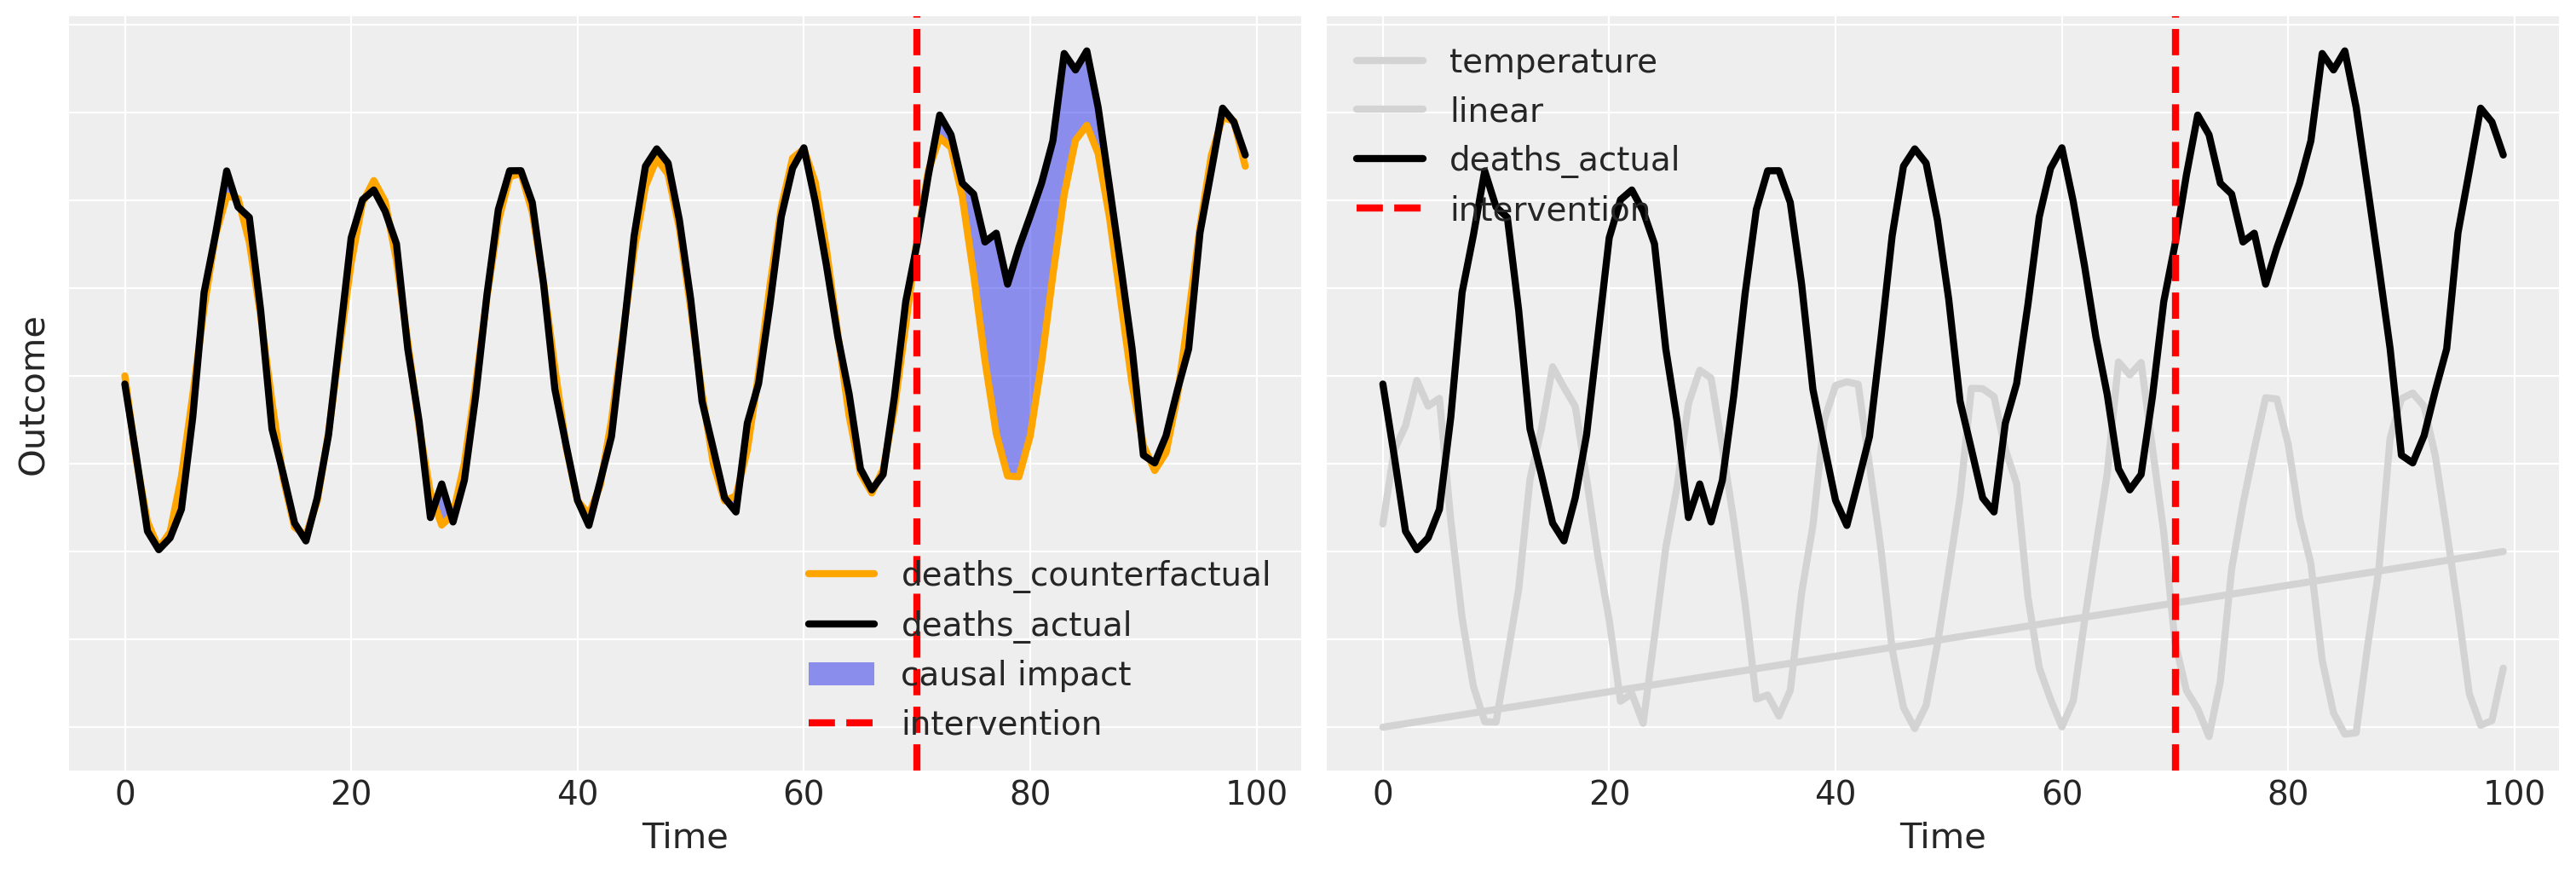

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# WHAT YOU WANT
df.loc[:, ['deaths_counterfactual']].plot(c='orange', lw=3, ls="-", ax=ax[0])
df.loc[:, ['deaths_actual']].plot(c='k', ax=ax[0], lw=3)
# causal effect shading
ax[0].fill_between(df.index, df['deaths_counterfactual'], df['deaths_actual'], alpha=0.5, label='causal impact')
# formatting
ax[0].set(xlabel="Time", ylabel="Outcome", yticklabels=[])
ax[0].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention')
ax[0].legend()

# WHAT YOU HAVE
df.loc[:, ['temperature', 'linear']].plot(c='lightgrey', lw=3, ax=ax[1])
# # df.loc[:, ['counterfactual']].plot(c='orange', lw=3, ls="-", ax=ax[1])
df.loc[:, 'deaths_actual'].plot(c='k', ax=ax[1], lw=3)
# formatting
ax[1].set(xlabel="Time", ylabel="Outcome", yticklabels=[])
ax[1].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention')
ax[1].legend();

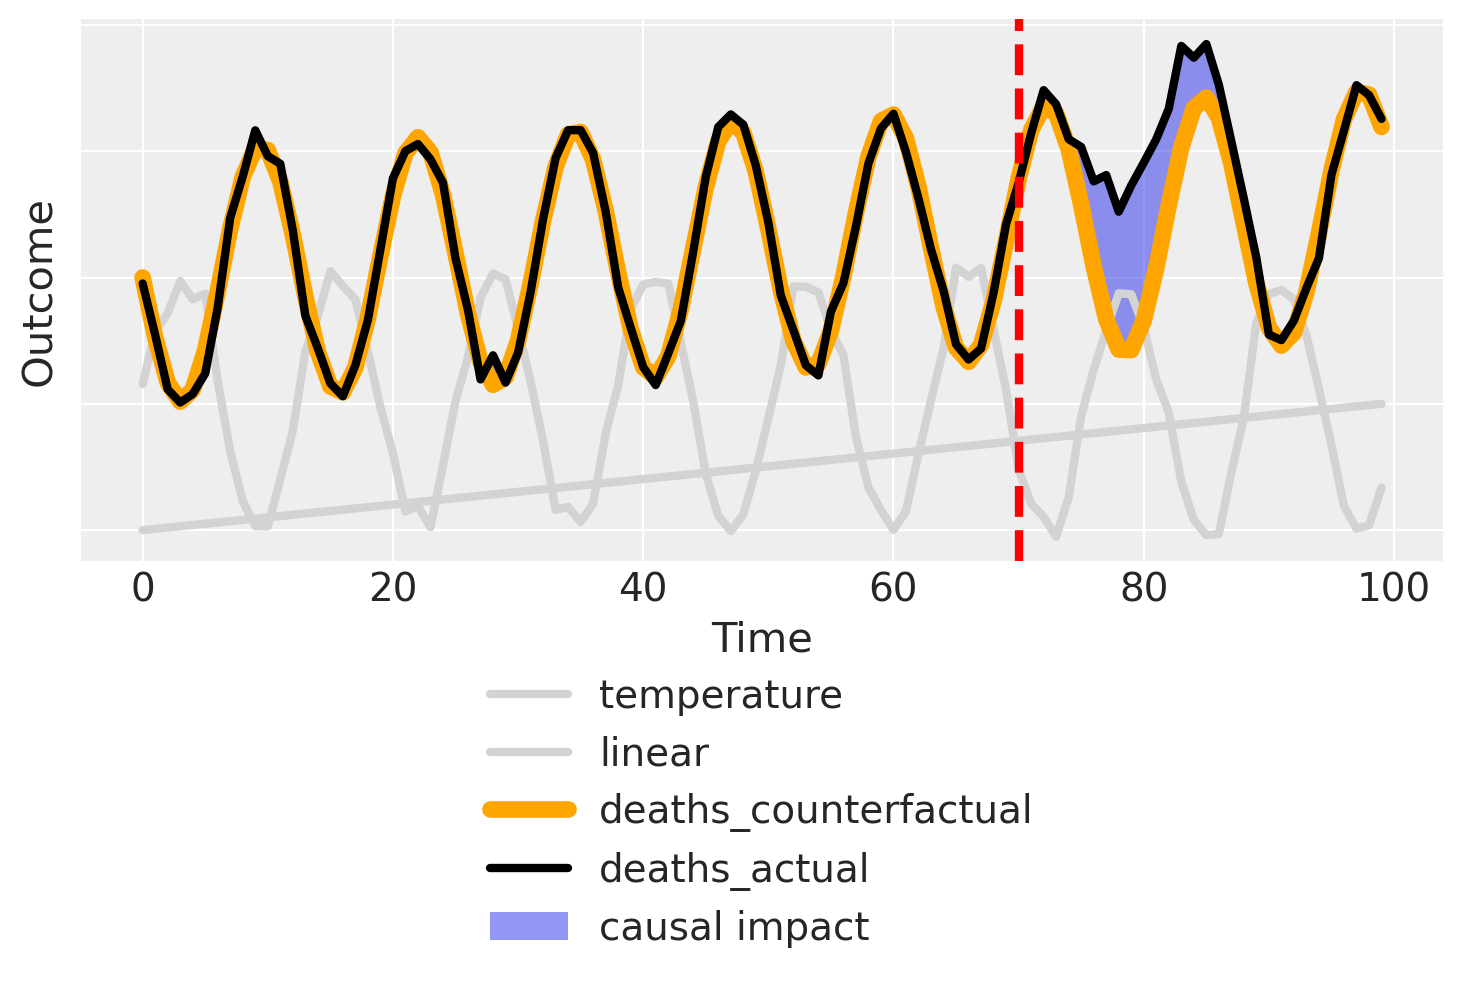

In [6]:
ax = df.loc[:, ['temperature', 'linear']].plot(c='lightgrey', lw=3)
df.loc[:, ['deaths_counterfactual']].plot(c='orange', ax=ax, lw=6, ls="-")
df.loc[:, ['deaths_actual']].plot(c='k', ax=ax, lw=3)

# causal effect shading
ax.fill_between(df.index, df['deaths_counterfactual'], df['deaths_actual'], alpha=0.5, label='causal impact')

# formatting
ax.set(xlabel="Time", ylabel="Outcome", yticklabels=[])
ax.axvline(x=treatment_time, linewidth=3, c='r', ls='--')
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center');

## Do inference

See if we can infer the causal impact accurately by estimating a synthetic control

In [7]:
result = LinearModel(df, 
                     treatment_date=treatment_time, 
                     target_var="deaths_actual",
                     predictor_vars=['temperature', 'linear', 'intercept'])

PRIOR PREDICTIVE CHECK
INFERENCE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 11 seconds.


POSTERIOR PREDICTIVE CHECK


COUNTERFACTUAL INFERENCE


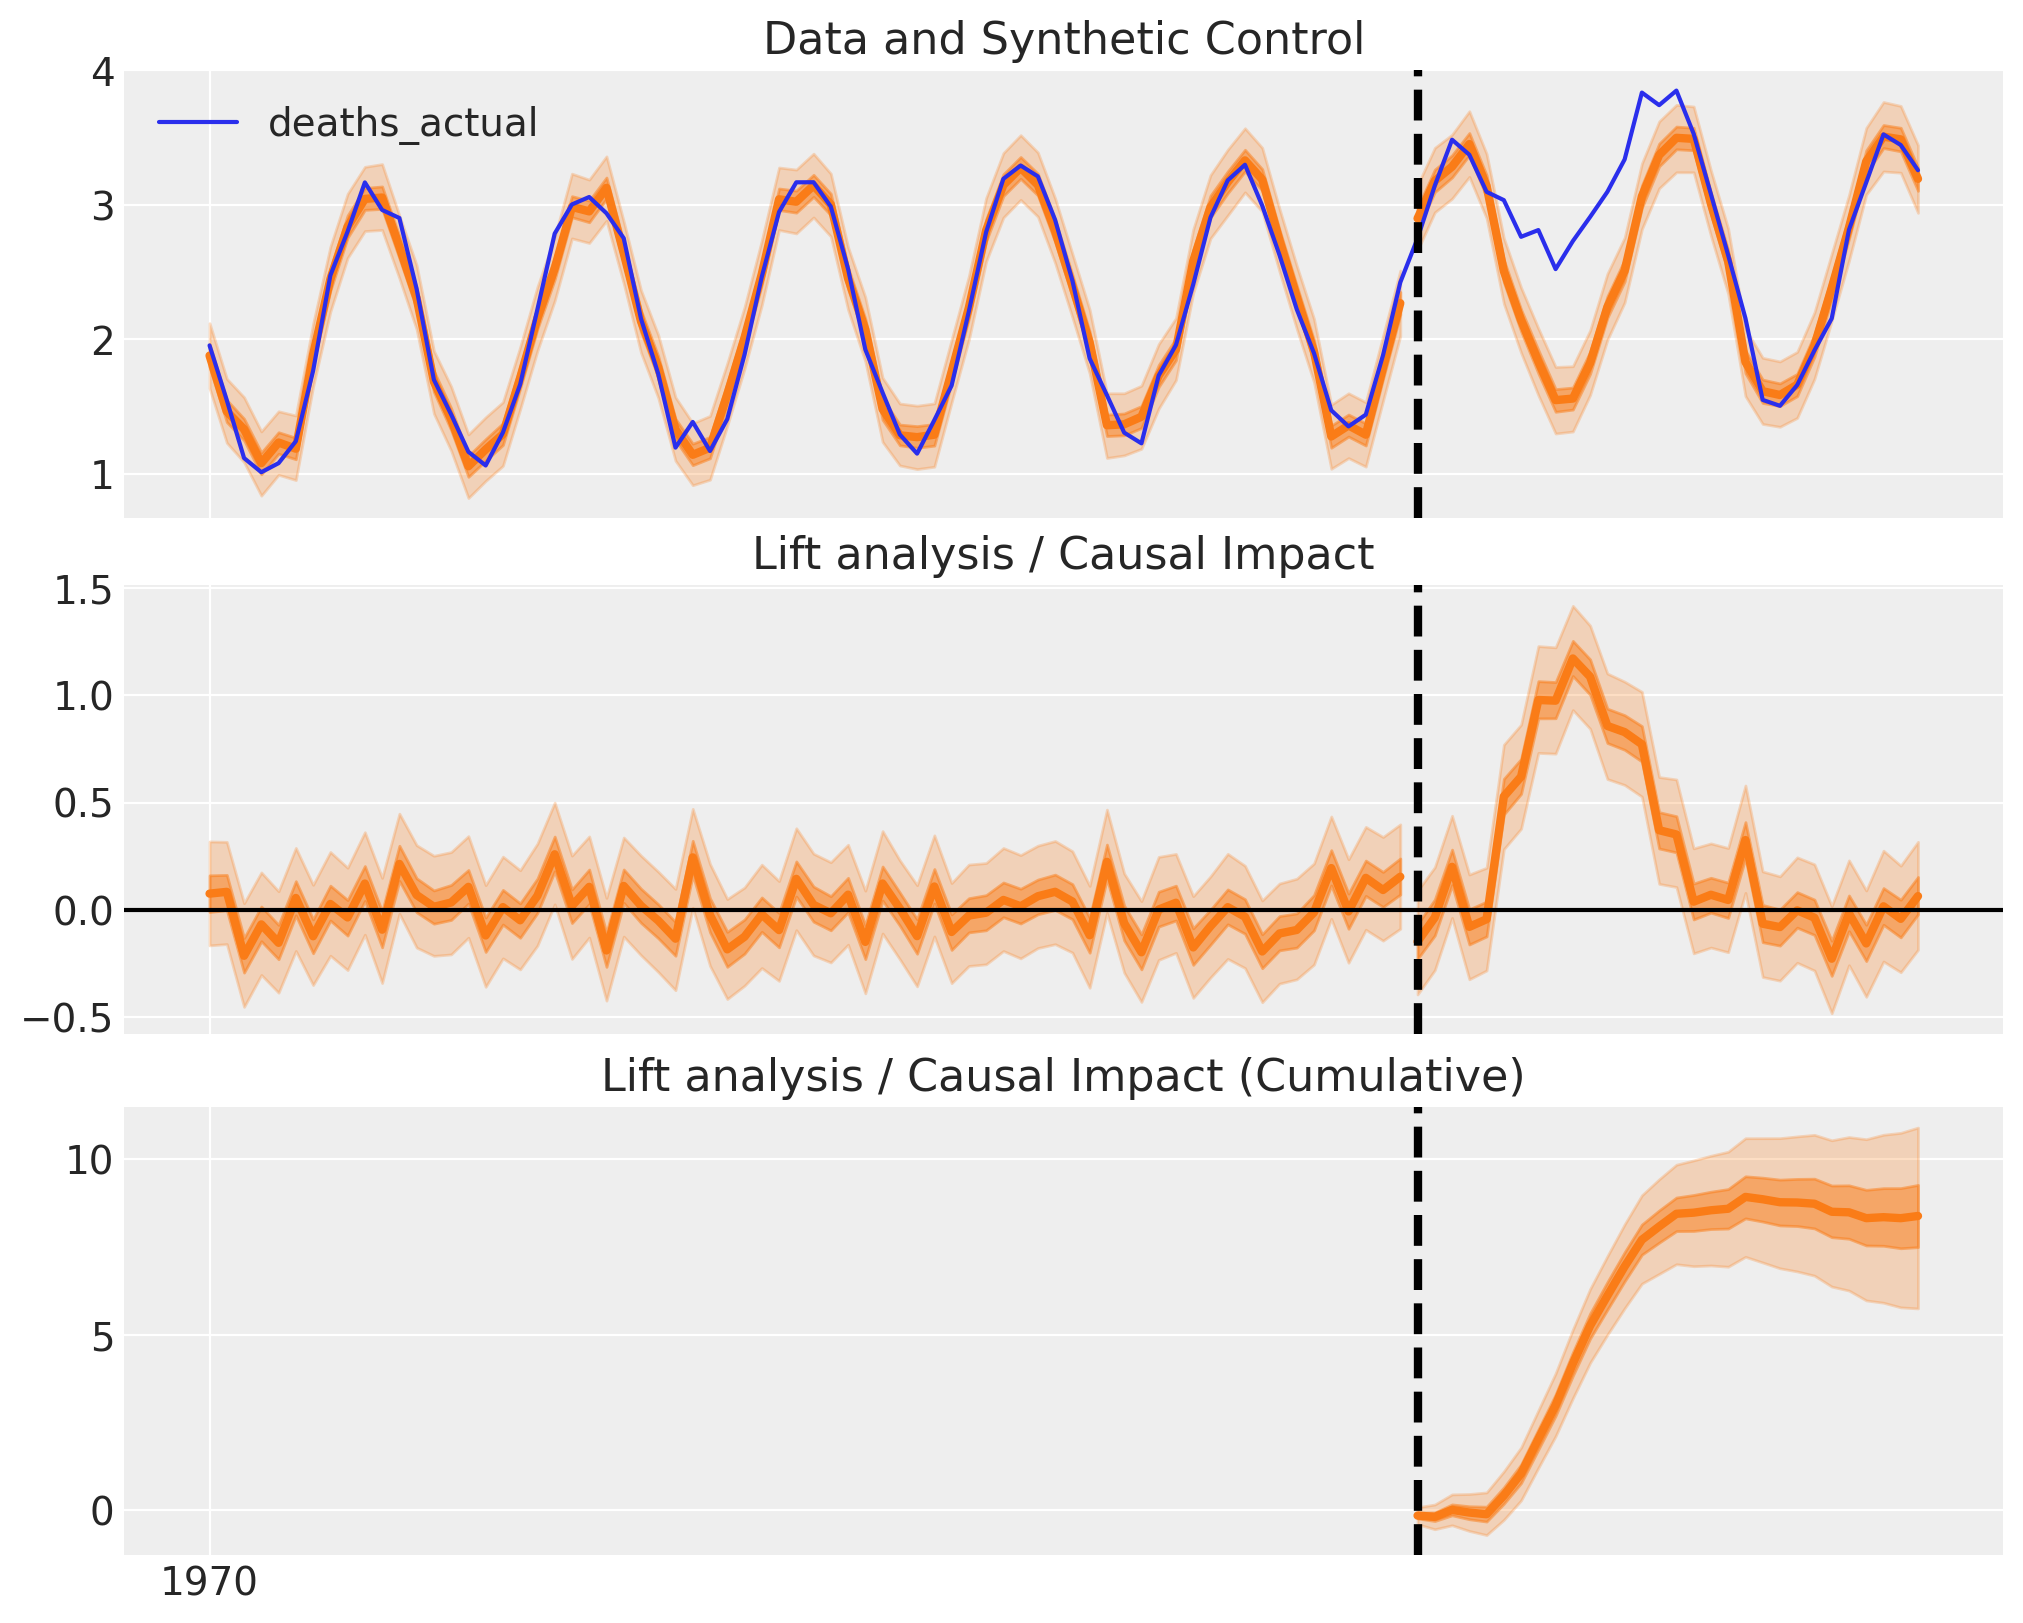

In [8]:
result.plot()

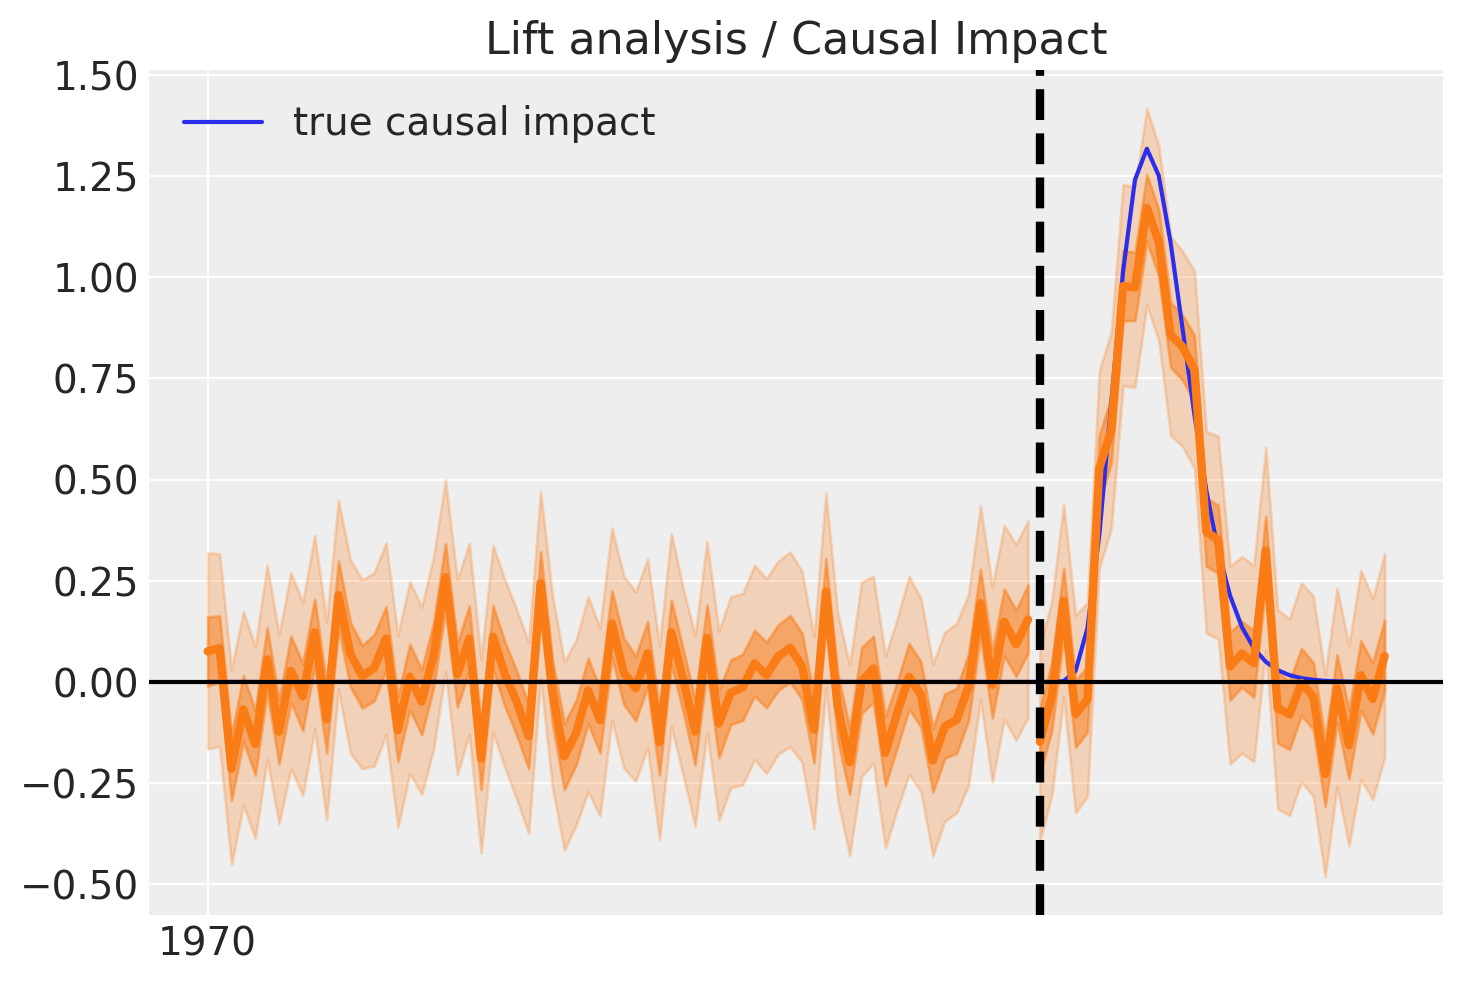

In [9]:
fig, ax = plt.subplots()
ax.plot(df['causal effect'], label='true causal impact')
result.plot_causal_impact(ax=ax)
ax.legend();

Visualise the posterior distributions of the variable weightings.

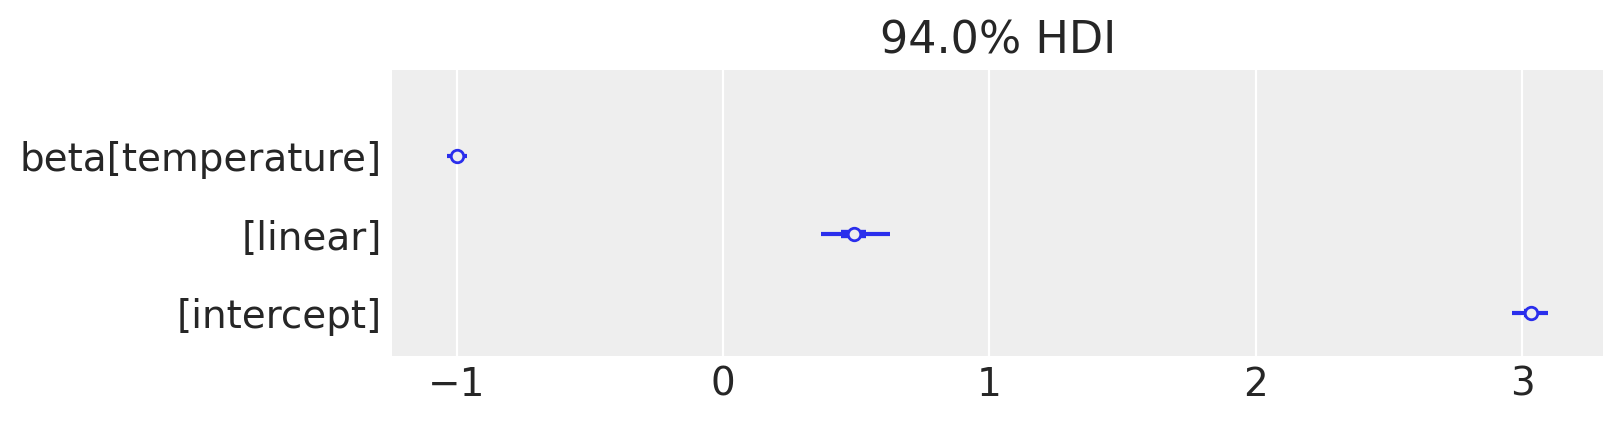

In [10]:
az.plot_forest(result.idata_pre.posterior, var_names="beta", figsize=(8, 2), combined=True);

A similar plot of the posterior distributions of variable weightings, but this time with ground truth of the simulated data.

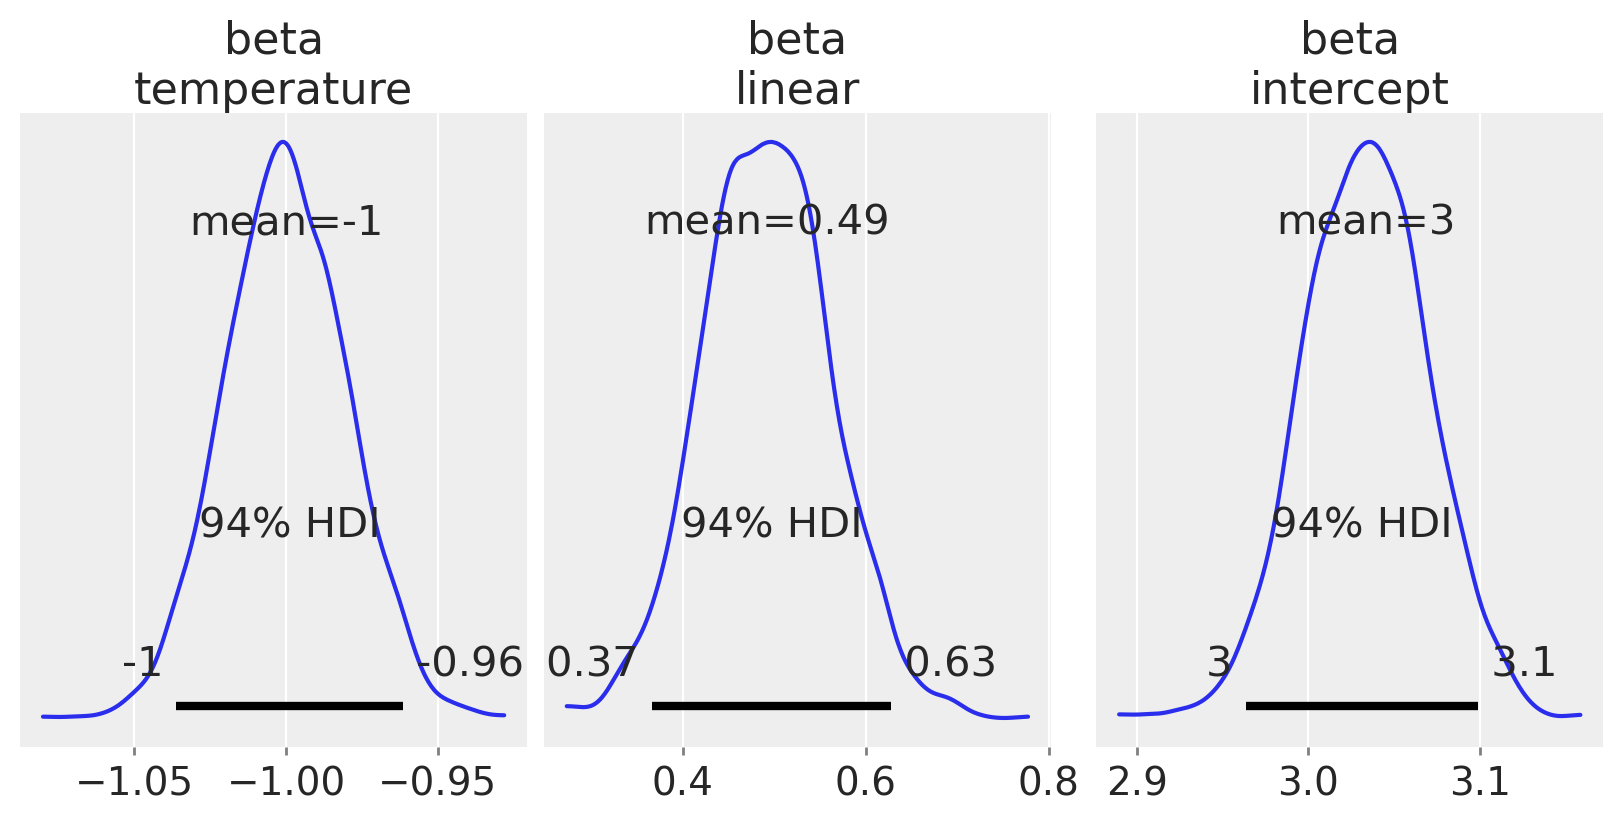

In [11]:
az.plot_posterior(result.idata_pre.posterior['beta'], figsize=(8, 4));